---
title: " Sensibilidad al pardeamiento del raquis de uva de mesa"
---


In [29]:

# Import librerias necesarias
import pandas as pd
import openpyxl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression


## Resultados

### 1. Caracterizacion inicial a cosecha 

In [30]:
#cargar datos caracterizacion inicial
Cosecha = pd.read_excel(r'../datos/caracterizacion inicial.xlsx')
df = pd.DataFrame(Cosecha)

df.columns = df.columns.str.strip() # Normalizar nombres de columnas 

# Filtro de datos de acuerdo evaluacion 0h,3h,18h 
df_filtrado = df[df["Evaluacion"].isin(["E00", "E03", "E18"])]

# Tabla resumen de caracterizacion inicial 
df_resumen =(df_filtrado.groupby('Variedad')
             [['TSS','Acidez_titulable', 'Peso', 'Calibre_Ecuatorial', 'Firmeza']] 
.agg(['mean', 'std','count']) 
.round(2) 
.reset_index() 
) 
# creamos un tabal media + DE
tabla_resumen = pd.DataFrame()
tabla_resumen["Variedad"] = df_resumen["Variedad"]

for var in ["TSS", "Acidez_titulable", "Peso", "Calibre_Ecuatorial", "Firmeza"]:
    tabla_resumen[var] = df_resumen.apply(
        lambda x: f"{x[(var, 'mean')]:.2f} ± {x[(var, 'std')]:.2f}", axis=1
    )

# Renombrar encabezados
tabla_resumen = tabla_resumen.rename(columns={
    "TSS": "TSS (°Brix)",
    "Acidez_titulable": "Acidez Titulable (g/L)",
    "Peso": "Peso (g)",
    "Calibre_Ecuatorial": "Calibre (mm)",
    "Firmeza": "Firmeza (gf mm-1)"
})

tabla_resumen

,Variedad,TSS (°Brix),Acidez Titulable (g/L),Peso (g),Calibre (mm),Firmeza (gf mm-1)
0,AL,19.04 ± 1.04,0.64 ± 0.07,10.18 ± 1.82,22.57 ± 1.58,322.48 ± 64.59
1,SC,18.04 ± 0.80,0.78 ± 0.09,9.03 ± 1.61,23.60 ± 1.54,242.69 ± 18.44


### 2. Relación de acuedo hue inicial, Contenido Relativo del agua

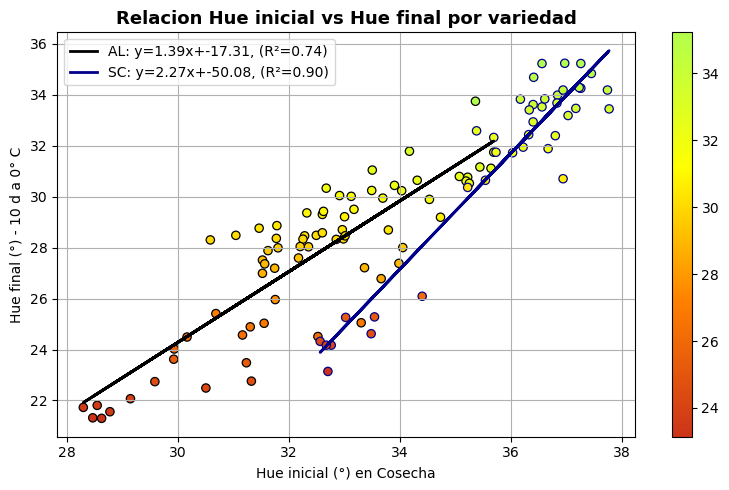

In [52]:
# Cargamos archivos 
# =====================================================================================
datos_correlacion = pd.read_csv(r'../datos/Pardeamiento uva de mesa.csv', sep=';')

df = pd.DataFrame(datos_correlacion)
df.columns = df.columns.str.strip()  # Normalizar nombres de columnas 

# Crear un identificador único por racimo
df['ID'] = (df['Variedad'].astype(str) + '_' +
            df['Productor'].astype(str) + '_' +
            df['Tratamientos'].astype(str) + '_' +
            df['Repeticion'].astype(str) + '_' +
            df['N_Racimo'].astype(str))

# Pivotar para tener columnas separadas
tabla_correlaciones = (
    df.pivot_table(
        index=['Variedad', 'ID'],
        columns='Tiempo',
        values='Hue'
    )
    .reset_index()
    .round(2)  # redondear a 2 decimales
)

# Colormap personalizado
colors = [
    (0.8, 0.2, 0.1),   # Rojo
    (1.0, 0.5, 0.0),   # Naranja
    (1.0, 1.0, 0.0),   # Amarillo
    (0.7, 1.0, 0.3)    # Verde amarillento
]
cmap_rav = mcolors.LinearSegmentedColormap.from_list("rojo_amarillo_verde", colors, N=256)

# Crear figura
plt.figure(figsize=(8, 5))
variedades = tabla_correlaciones['Variedad'].unique()

# Colores distintos para las líneas
colores_linea = ['black', 'darkblue']

# Colores de borde por variedad
colores_borde = {
    'AL': 'black',
    'SC': 'darkblue'
}

# === Scatter con borde por variedad ===
for variedad in variedades:
    datos_var = tabla_correlaciones[tabla_correlaciones['Variedad'] == variedad]

    plt.scatter(
        datos_var['T0'],
        datos_var['T10'],
        c=datos_var['T10'],     # color interior
        cmap=cmap_rav,
        edgecolors=colores_borde[variedad],  # borde diferenciado
        linewidth=0.9
    )

# === Regresión lineal por variedad ===
for i, variedad in enumerate(variedades):
    datos = tabla_correlaciones[tabla_correlaciones['Variedad'] == variedad]
    X = datos[['T0']].values
    y = datos['T10'].values
    
    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)

    r2 = r2_score(y, y_pred)
    pendiente = modelo.coef_[0]
    intercepto = modelo.intercept_

    plt.plot(
        X, y_pred,
        color=colores_linea[i % len(colores_linea)],
        lw=2,
        label=f'{variedad}: y={pendiente:.2f}x+{intercepto:.2f}, (R²={r2:.2f})'
    )

# Etiquetas y formato
plt.xlabel('Hue inicial (°) en Cosecha')
plt.ylabel('Hue final (°) - 10 d a 0° C')
plt.title('Relacion Hue inicial vs Hue final por variedad', fontsize=13, weight='bold')
plt.colorbar()
plt.grid(True)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()


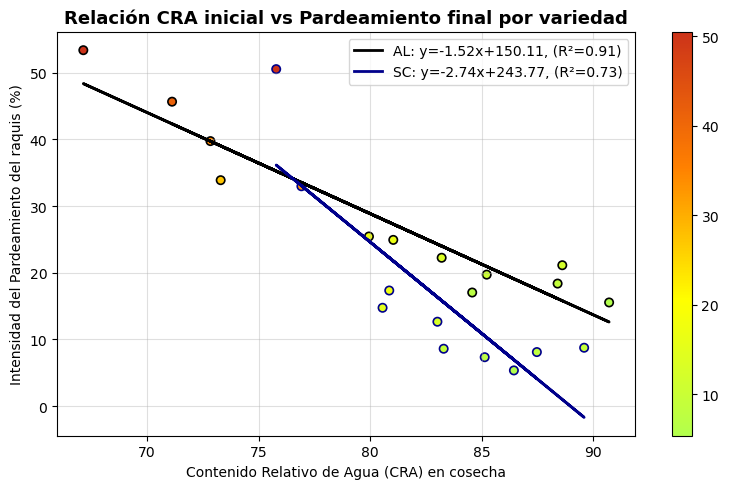

In [56]:
#  Correlacion de acuerdo CRA vs pardeamiento 
datos_CRA = pd.read_csv(r'../datos/Contenido relativo de agua.csv', sep=';')

# Calculamos el promedio  CAR en T0
CRA_promedio_T0 = (
    datos_CRA
    .groupby(['Productor', 'Variedad', 'Color', 'Tratamientos'])['CAR']
    .mean()
    .round(2)
    .reset_index()
)

# Filtrar pardeamiento T10
Pardo_t10 = df[df['Tiempo'] == 'T10']

# Calculamos el promedio pardeamiento T10
Pardo_promedio_T10 = (
    Pardo_t10
    .groupby(['Productor', 'Variedad', 'Color', 'Tratamientos'])['Pardo']
    .mean()
    .round(2)
    .reset_index()
)

# Unión de los promedios
CAR_VS_PAR = pd.merge(
    CRA_promedio_T0,
    Pardo_promedio_T10,
    on=['Productor', 'Variedad', 'Color', 'Tratamientos']
)

# Colormap
colors = [
    (0.7, 1.0, 0.3),   # Verde amarillento
    (1.0, 1.0, 0.0),   # Amarillo
    (1.0, 0.5, 0.0),   # Naranja
    (0.8, 0.2, 0.1)    # Pardo/rojo degradado
]
cmap_rav1 = mcolors.LinearSegmentedColormap.from_list("verde_a_pardo", colors, N=256)

# Crear gráfico
plt.figure(figsize=(8, 5))
variedades = CAR_VS_PAR['Variedad'].unique()

# Colores de línea (puedes cambiarlos si quieres)
colores_linea = ['black', 'darkblue']

# Colores de borde recomendados por variedad
colores_borde = {
    'AL': 'black',
    'SC': 'darkblue'
}

# === Scatter con borde por variedad ===
for variedad in variedades:
    datos_var = CAR_VS_PAR[CAR_VS_PAR['Variedad'] == variedad]

    plt.scatter(
        datos_var['CAR'],
        datos_var['Pardo'],
        c=datos_var['Pardo'],          # color interior por colormap
        cmap=cmap_rav1,
        edgecolors=colores_borde[variedad],  # borde diferenciado
        linewidth=1.2
    )

# === Regresión lineal por variedad ===
for i, variedad in enumerate(variedades):
    datos = CAR_VS_PAR[CAR_VS_PAR['Variedad'] == variedad]
    X = datos[['CAR']].values
    y = datos['Pardo'].values
    
    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)
    
    r2 = r2_score(y, y_pred)
    pendiente = modelo.coef_[0]
    intercepto = modelo.intercept_
    
    plt.plot(
        X, y_pred,
        color=colores_linea[i % len(colores_linea)],
        lw=2,
        label=f'{variedad}: y={pendiente:.2f}x+{intercepto:.2f}, (R²={r2:.2f})'
    )

# Formato final
plt.xlabel('Contenido Relativo de Agua (CRA) en cosecha')
plt.ylabel('Intensidad del Pardeamiento del raquis (%)')
plt.title('Relación CRA inicial vs Pardeamiento final por variedad', fontsize=13, weight='bold')
plt.colorbar()
plt.grid(alpha=0.4)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()


### 3. Almacenamiento comercial en postcosecha. 

Revisara si las varibles de acuerdo el color en cosecha influyen en el pardeamiento del raquis de uva de mesa de amabas variedades. 

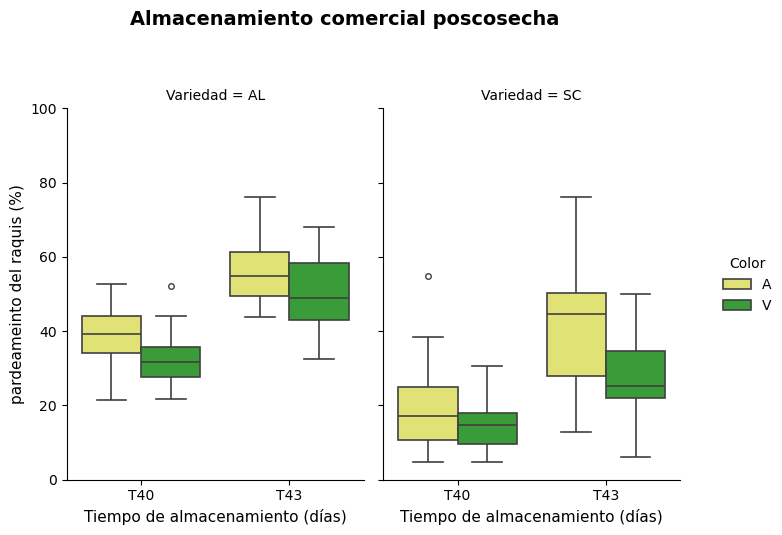

In [ ]:
# Cargar datos
df = pd.read_csv(r'../datos/Almacenamiento comercial.csv', sep=';')
df.columns = df.columns.str.strip()

# Orden de niveles de tiempo
orden_tiempo = ['T40', 'T43']
if set(orden_tiempo).issuperset(df['Tiempo'].unique()):
    df['Tiempo'] = pd.Categorical(df['Tiempo'], categories=orden_tiempo, ordered=True)

# Paleta de colores
colores = {
    'A': "#f2f464",   # Amarillo
    'V': "#29ac29"    # Verde
}

# Crear boxplot facetado con tamaño ajustado
g = sns.catplot(
    data=df,
    kind='box',
    x='Tiempo',
    y='Pardo',
    hue='Color',
    col='Variedad',
    palette=colores,
    height=5,          # ← Alto de cada subfigura
    aspect=1.2,        # ← Relación ancho/alto
    fliersize=4,
    linewidth=1.2
)

# Ajustar tamaño total de la figura
g.fig.set_size_inches(7, 5)   

# Ajustar leyenda
g._legend.set_bbox_to_anchor((1.12, 0.5))

# Ajustes finales — Escala Y fija
for ax in g.axes.flatten():
    ax.set_ylim(0, 100)
    ax.set_ylabel("pardeameinto del raquis (%)", fontsize=11)
    ax.set_xlabel("Tiempo de almacenamiento (días)", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

# Título general
g.fig.suptitle(
    "Almacenamiento comercial poscosecha",
    y=1.06,
    fontsize=14,
    fontweight='bold'
)

plt.tight_layout()
plt.show()
